# Dynamische Bezierinterpolation über eine definierte Anzahl zu einer stetig differenzierbaren, knickfreien und geschlossenen Kurve
In dieser Hausarbeite wurde mittels der Bezierinterpolation eine Achterbahnkurve gezeichnet, die zwischen einem vorher definierten Track interpoliert. Die Anforderungen an diese Kurve waren eine mögliche dreifache Ableitung, Knick- und Ruckfreiheit. Entstanden ist die Hausarbeit in Ahnlehnung an das Achterbahn Projekt der TU-Braunschweig (LINK). 

In [30]:
import csv
import os
import numpy as np 
from sympy import *
from scipy.integrate import RK45 
import matplotlib.pyplot as plt
import math
import re
%matplotlib notebook
#%matplotlib inline

## Formel für die Krümmung am Zeitpunkt t
Im Folgenden ist die Formel für die Krümmung einer regulären Kurve definiert:
$\kappa(t) = \frac{\dot c \times \ddot c}{\|\dot c \|^3}$

Diese definieren wir als eine Funktion, die uns eine Lambda-Funktion zurückliefert.

In [31]:
 def curvature_at_t(bezier_cubic_first_deriv, bezier_cubic_second_deriv):
    return lambda t: (np.cross((bezier_cubic_first_deriv(t)), (bezier_cubic_second_deriv(t)))) / np.power(np.linalg.norm(bezier_cubic_first_deriv(t)),3)

## Formel für die Torsion zum Zeitpunkt t
Im Folgenden ist die Formel für die Krümmung einer regulären Kurve definiert:

$\tau(t) = \frac{(\dot c \times \ddot c ) \cdot \dddot c}{\| \dot c \times \ddot c \|^2}$

Diese definieren wir als eine Funktion, die uns eine Lambda-Funktion zurückliefert.

In [32]:
def torsion_at_t(bezier_cubic_first_deriv, bezier_cubic_second_deriv, bezier_cubic_third_deriv):
    return lambda t: (np.cross(bezier_cubic_first_deriv(t), bezier_cubic_second_deriv(t))*bezier_cubic_third_deriv(t)) 
    /np.power(np.linalg.norm(np.cross(bezier_cubic_first_deriv(t), bezier_cubic_second_deriv(t))),2)

## Formeln für Frenet-Dreibein
Das Frenet-Dreibein entlang der Achterbahnkurve zeichnen wir mittels des Tangentialvektors, der Binormalverkotrs und des Normalvektors.

### Formel für den Tangentialvektor
Im Folgenden ist die Formel für den normierten Tangentialvektor definiert:

$T(t) = \frac{\dot C}{\|\dot C\|}$

Diese schreiben wir als Funktion, die uns eine Lambda-Funktion zurückliefert.

In [201]:
def tangent_at_t(bezier_cubic_first_deriv):
    return lambda t: bezier_cubic_first_deriv(t) / np.linalg.norm(bezier_cubic_first_deriv(t))

### Formel für den Binormalvektor
Im Folgenden ist die Formel für den normierten Tangentialvektor definiert:

$B(t) = \frac{\dot C \times \ddot C}{\|\dot C \times \ddot C\|}$

Diese schreiben wir als Funktion, die uns eine Lambda-Funktion zurückliefert.

In [202]:
def binormal_at_t(bezier_cubic_first_deriv, bezier_cubic_second_deriv):
    return lambda t: np.cross(bezier_cubic_first_deriv(t), bezier_cubic_second_deriv(t)) / np.linalg.norm(np.cross(bezier_cubic_first_deriv(t), bezier_cubic_second_deriv(t)))

### Formel für den Normalenvektor
Im Folgenden ist die Formel für den normierten Tangentialvektor definiert:

$N(t) = B \times T$

Diese schreiben wir als Funktion, die uns eine Lambda-Funktion zurückliefert.

In [35]:
def normal_at_t(tangent_at_t, binormal_at_t):
    return lambda t: np.cross(binormal_at_t(t), tangent_at_t(t))

## Einlesen oder Erzeugen der Punkte
Um Samples für die Bezierinterpolation zu erstellen, stehen in diesem Programm mehrere Möglichkeiten zur Auswahl. Zum einen können diese völlig zufällig erstellt werden. In diesem Fall übergeben wir der Funktion create_points einfach einen leeren String. Außerdem lassen sich vorher definierte Track-Dateien einlesen. Hierfür muss der Funktion create_points der Pfad zu der entsprechenden Track-Datei übergeben werden.


In [36]:
def create_points(filename):
    if (filename != ""):
        rel_path = filename+'.trk'
        abs_file_path = os.path.join('Tracks', rel_path)
        points = []
        file = open(abs_file_path,'r')  
        
        for row in file:            
            if ("#" in row):
                pass
            elif ("Track" in row):
                pass
            elif (" " in row):
                # first clean the row
                x,y,z = row.split()
                points.append(np.array([float(x), float(y), float(z)]))
               
            
    else: 
        #points = np.random.randfloat(10,3) * 3
        points = np.random.uniform(-10,10,[5,3])
    return points

## Erzeugen der Bezier-Coeffizienten
Die Funktion für eine kubische Bezierkurve ist wie folgt definiert:

$B(s) = (1-s)^3\begin{bmatrix} p_{0,1} \\ p_{0,2} \\ p_{0,3} \end{bmatrix} + 3(1-s)^2s \begin{bmatrix} p_{1,1} \\ p_{1,2} \\ p_{1,3} \end{bmatrix} + 3(1-s)^2s \begin{bmatrix} p_{2,1} \\ p_{2,2} \\ p_{2,3} \end{bmatrix} + s^2 \begin{bmatrix} p_{3,1} \\ p_{3,2} \\ p_{3,3} \end{bmatrix}$

Hierbei ist sie über vierPpunkte definiert. 

$\vec p_0,\vec p_1,\vec p_2,\vec p_3$

Wobei die Splines der Bezierkurve durch $\vec p_1$ und $\vec p_2$ und die Samplepunkte jeweils als die Punkte $\vec p_0$ und $\vec p_3$ definiert sind. Letztere kennen wir, sie sind die Punkte, die wir mit der Funktion create_points erhalten. Nun gilt es die Punkte $\vec p_1$ und \vec $p_2$ für die jeweilige Bezierkurve herauszufinden. Hierfür stellen wir einen Lineares Gleichungssystem aus den Folgenden Bedingungen auf:



In [212]:
def get_bezier_coef(points):
    C = np.zeros((len(points), len(points)), dtype=float)
    # Create coefficent matrix
    for i, row in enumerate(C):
        math_i = i 
        a_i_index = math_i % len(points)
        a_i_one = (math_i+1) % len(points) 
        a_i_two = (math_i+2) % len(points) 

        C[i,a_i_index] = 1
        C[i,a_i_one] = 4
        C[i,a_i_two] = 1
    # letzte zeile setzen
     
    # Build points vector    
    P = np.array([4 * points[(i+1) % len(points)] + 2* points[(i+2)%len(points)] for i in range(len(points))], dtype=float)

    #P[n] = np.array(4* points[0] + 2*points[1])
    P = np.array(P)
    A = np.array(np.linalg.solve(C, P),  dtype=float)
    
    B = np.zeros((len(points),3), dtype=float)

    for i in range(len(points)):
        B[i] = 2 * points[(i+1) % len(points)] - A[(i+1) % len(points)]
    #B[n] = (A[n] + points[n]) / 2
    
    return A,B

def get_gravity():
    return np.array([0,0,1]) 

def get_mass():
    return 20

# returns the general Bezier cubic formula given 4 control points
def get_bezier_cubic(p0, p1, p2, p3):
    return lambda t: np.power(1 - t, 3) * p0 + 3 * np.power(1 - t, 2) * t * p1 + 3 * (1 - t) * np.power(t, 2) * p2 + np.power(t, 3) * p3

# first derivative of the berzier curve formula
def get_bezier_cubic_first_deriv(p0, p1, p2, p3):
    return lambda t: -3*p0*np.power(1 - t, 2) + 3*p1*np.power(1 - t, 2) - 6*p1*(1 - t) * t + 6 * p2*(1 - t) * t - 3 * p2 * np.power(t,2) + 3*p3 * np.power(t,2)

# seconds derivative of the berzier curve formula
def get_bezier_cubic_second_deriv(p0, p1, p2, p3):
    return lambda t: 6 * p0 * (1 - t) - 12 * p1 * (1 - t) + 6 * p1 * t + 6 * p2 * (1 - t) - 12 * p2 * t + 6 * p3 * t

# third derivative of the bezier curve formular
def get_bezier_cubic_third_deriv(p0, p1, p2, p3):
    return lambda t: -6*p0 + 12*p1 + 6*p1 -6*p2 - 12*p2 + 6*p3


# euclidian norm
def euclidean_norm(bezier_cubic_first_deriv):
    return lambda t: np.linalg.norm(bezier_cubic_first_deriv(t), ord=2)
    

def get_distance_betweem(p0, p1):
    return p1 - p0


def get_all_functions(points):
    A, B = get_bezier_coef(points)
    
    # cubics
    bezier_cubics = [get_bezier_cubic(points[i], A[i], B[i], points[(i + 1)% len(points)]) for i in range(len(points))]
    bezier_cubics_first_deriv = [get_bezier_cubic_first_deriv(points[i], A[i], B[i], points[(i + 1)% len(points)]) for i in range(len(points))]
    bezier_cubics_second_deriv = [get_bezier_cubic_second_deriv(points[i], A[i], B[i], points[(i + 1)% len(points)]) for i in range(len(points))]
    bezier_cubics_third_deriv = [get_bezier_cubic_third_deriv(points[i], A[i], B[i], points[(i + 1)% len(points)]) for i in range(len(points))]
    # Curvature and torsion
    curvature = [curvature_at_t(bezier_cubics_first_deriv[i], bezier_cubics_second_deriv[i]) for i in range(len(points))]
    torsion = [torsion_at_t(bezier_cubics_first_deriv[i], bezier_cubics_second_deriv[i], bezier_cubics_third_deriv[i])for i in range(len(points))]
    #Frenet dreibein
    tangent = [tangent_at_t(bezier_cubics_first_deriv[i]) for i in range(len(points))]
    binormal = [binormal_at_t(bezier_cubics_first_deriv[i], bezier_cubics_second_deriv[i]) for i in range(len(points))]
    normal = [normal_at_t(tangent[i], binormal[i]) for i in range(len(points))]
    # Get new functions
    #energy_functions = [energy(bezier_cubics[i], bezier_cubics_first_deriv[i]) for i in range(len(points))]
    #parametric_velocity_functions = [parametric_velocity(energy_functions[i], bezier_cubics[i], bezier_cubics_first_deriv[i]) for i in range(len(points))]
    #parametric_acceleration_functions = [parametric_acceleration(bezier_cubics[i], parametric_velocity_functions[i], bezier_cubics_first_deriv[i], bezier_cubics_second_deriv[i]) for i in range(len(points))]
    
    all_functions = {
        'bezier_cubics': bezier_cubics,
        'bezier_cubics_first_deriv': bezier_cubics_first_deriv, 
        'bezier_cubics_second_deriv': bezier_cubics_second_deriv,
        'bezier_cubics_third_deriv': bezier_cubics_third_deriv,
        'curvature': curvature, 
        'torsion': torsion,
        'tangent': tangent,
        'binormal': binormal,
        'normal': normal
        
        #'energy_functions': energy_functions,
        #'parametric_velocity_functions': parametric_velocity_functions,
        #'parametric_acceleration_functions': parametric_acceleration_functions
    }
    
    return all_functions
    
# evalute each cubic curve on the range [0, 1] sliced in n points
def evaluate_bezier(points, n):
    curves = get_all_functions(points)['bezier_cubics']
    return np.array([fun(t) for fun in curves for t in np.linspace(0, 1, n)])

def get_all_curve_data(all_curve_functions, n, sample_count=100):
    curve_points = []
    curve_speeds = []
    curve_accelerations = []
    curve_jolt = []
    curve_curvature = []
    curve_torsion = []
    curve_tangent = []
    curve_binormal = []
    curve_normal = []
    
    ts = []
        
    length_of_curve_at_t = []
    
    last_length = 0
    last_curve_point = all_curve_functions['bezier_cubics'][0](0)

    for t in np.linspace(0, n, sample_count * n):
        ts.append(t)
        seperated_t = math.modf(t%n)
        segment_index = int(seperated_t[1])
        curve_index = seperated_t[0]
        # here calculate all the values for the current t
        # curve point (pure geometry)
        current_curve_point = all_curve_functions['bezier_cubics'][segment_index](curve_index) 
        curve_points.append(current_curve_point)
        #speed at t
        curve_speeds.append(all_curve_functions['bezier_cubics_first_deriv'][segment_index](curve_index))
        #acceleration at t
        curve_accelerations.append(all_curve_functions['bezier_cubics_second_deriv'][segment_index](curve_index))
        # jolt (ruck) at t
        curve_jolt.append(all_curve_functions['bezier_cubics_third_deriv'][segment_index](curve_index))
        
        # curvature at t
        curve_curvature.append(all_curve_functions['curvature'][segment_index](curve_index))
        # torsion at t
        curve_torsion.append(all_curve_functions['torsion'][segment_index](curve_index))
                
        # Frenet Dreibein
        curve_tangent.append(all_curve_functions['tangent'][segment_index](curve_index))
        curve_binormal.append(all_curve_functions['binormal'][segment_index](curve_index))
        curve_normal.append(all_curve_functions['normal'][segment_index](curve_index))
    
        # get approximated length of the curve at t
        current_length = abs(float(np.linalg.norm(current_curve_point - last_curve_point)))

        total_length = last_length + current_length
        last_curve_point = current_curve_point

        length_of_curve_at_t.append(total_length)
        #last_euclidean_norm = current_euclidean_norm
        last_length = total_length
    # create an index I evenly distributet over the Length Values         
    i_max = n
    I = []
    total = length_of_curve_at_t[len(length_of_curve_at_t)-1]
   

    for loc in length_of_curve_at_t:
        percentage = loc/total
        I.append(round(n*percentage,10))
            
    curve_data = {
        'geometry': np.array(curve_points),
        'speed': np.array(curve_speeds),
        'acceleration': np.array(curve_accelerations),
        'jolt': np.array(curve_jolt),
        'curvature': np.array(curve_curvature),
        'torsion': np.array(curve_torsion),
        'tangent': np.array(curve_tangent),
        'binormal': np.array(curve_binormal),
        'normal': np.array(curve_normal),
        'ts': np.array(ts),
        'curve_length': np.array(length_of_curve_at_t)
    }
    return curve_data

    

# Reading the points

In [204]:
samples = create_points("_markus")
n = len(samples)


## Berechnen aller Funktionen für die einzelnen Kurvenstücke

In [205]:
all_curve_functions = get_all_functions(samples)


### Generieren der Kurvendaten
In diesem Abschnitt berechnen wir die Verschiedenen Daten der Kurve und speichern sie in der variable **data**. Folgende Daten enthält sie für die einzelnen Punkte auf der Kurve: 
* Die Punkte im Raum
* Die Werte der ersten Ableitung (Tempo)
* Die Werte der zweiten Ableitung (Beschleunigung)
* Die Werte der dritten Ableitung (Ruck)
* Die Krümmung
* Die Torsion
* Den Tangentialvektor
* Den Binormalvektor
* Den Normalvektor
* Den Parameter t
* Die Länge der Kurve zum Zeitpunkt t (numerisch approximiert)

In [206]:
data = get_all_curve_data(all_curve_functions, n)

### Vorbereiten der Kurvendaten 

Anschließend bereiten wir die berechneten Kurvendaten vor, um sie anschließend zu plotten. Hierfür separieren wir zum einen die geometrischen Kurvenpunkte in die x-, y-, und z-Werte sowie die Krümmungswerte an den entsprechenden Punkten. Diese werden später benötigt, um die Kurve entsprechend der Krümmung einzufärben.

Wir zerteilen sowohl die geometrischen Kurvenpunkte, als auch die Krümmungswerte für jeden Parameter $t$ in Segmente.  

In [207]:
curves = data['geometry']
curves_x = curves[0:len(curves), 0]
curves_y = curves[0:len(curves), 1]
curves_z = curves[0:len(curves), 2]

curvatures = data['curvature']
curvatures_x = curvatures[0:len(curvatures), 0]
curvatures_y = curvatures[0:len(curvatures), 1]
curvatures_z = curvatures[0:len(curvatures), 2]

split_length = 1
# arrays for curve geometry
curve_segments = []
current_curve_batch = []
# arrays for curvature
curvature_segments = []
current_curvature_batch = []

curve_points = np.array([curves_x, curves_y, curves_z]).T.reshape(-1,1,3)
curve_segments = np.concatenate([curve_points[:-1], curve_points[1:]], axis=1)



curvature_norm_list = []
for curvature in curvatures:
    curvature_norm_list.append(np.linalg.norm(curvature))

curvature_points = np.array([curvature_norm_list]).T.reshape(-1,1,1)
curvature_segments = np.concatenate([curvature_points[:-1], curvature_points[1:]], axis=1)





Anschließend berechnen wir für jedes Segment einen durchschnittlichen Krümmungswert. Dieser bestimmt dann die Farbe des gesamten Segments

In [208]:
single_value_curvatures = []
for curvature in curvature_segments:
    median_curvature = np.median(curvature)
    single_value_curvatures.append(median_curvature)
    for i in range(0, len(curvature)):
        curvature[i] = median_curvature * 10

Nun erstellen wir eine Norm und mappen die Krümmung auf einen Farbbereich.

In [209]:
import matplotlib.cm as cm
import matplotlib
minima = min(single_value_curvatures)
maxima = max(single_value_curvatures)
norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('gist_ncar'))

# Animieren der Achterbahn
In diesem Abschnitt animieren und zeichnen wir die Achterbahn und die Achterbahnkurve. Zusätzlich zu der Achterbahn, welche im Animierten Graphen durch eine Kugel dargestellt wird, zeichnen wir die folgenden Werte für jeden Punkt $t$ ein:
* Die Tangente (Grün) $T(t)$
* Den Binormal-Vektor (Rot) $B(t)$
* Den Normal-Vektor(Blau) $N(t)$

Außerdem färben wir die Kruve selbst entsprechend der Krümmung ein. Die entsprechende Farbskala ist rechts neben dem Graphen dargestellt. Die Berechnung und Aufbereitung der Daten sind weiter im oben im Notebook zu finden.

In [210]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation

<IPython.core.display.Javascript object>


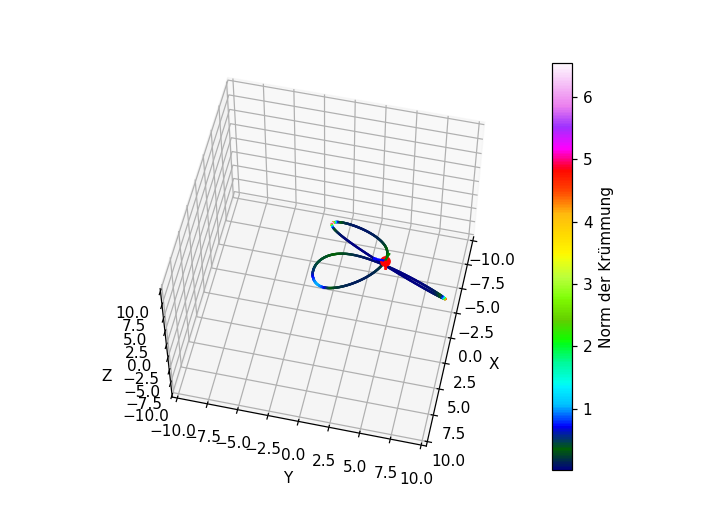

In [211]:
# 3d figure for showing the rollercoaster
fig = plt.figure()
#ax = p3.Axes3D(fig)
ax = fig.add_subplot(projection='3d')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_xlim3d(-10, 10)
ax.set_ylim3d(-10, 10)
ax.set_zlim3d(-10, 10)
#ax.legend()
tracks = []
for i,cs in enumerate(curve_segments):
    
    cs_x = cs[0:len(cs), 0]
    cs_y = cs[0:len(cs), 1]
    cs_z = cs[0:len(cs), 2]
    tracks.append(plt.plot(cs_x, cs_y, cs_z, c=mapper.to_rgba(single_value_curvatures[i])))

    
plt.colorbar(mappable=mapper, ax=ax, label="Norm der Krümmung")
    
#Durchgängiger plot
#track2 = plt.plot(curves_x, curves_y, curves_z,lw=0.1, c='b')

tangent_vector = plt.quiver(0,0,0,0,0,0)
binormal_vector = plt.quiver(0,0,0,0,0,0)
normal_vector = plt.quiver(0,0,0,0,0,0)
#calculate the curvedata

def func(num, data, rollercoaster):
    x = data['geometry'][num, 0]
    y = data['geometry'][num, 1]
    z = data['geometry'][num, 2]
    rollercoaster.set_data(x,y)
    rollercoaster.set_3d_properties(z)
    

    # Plotting the Tangential vector
    u_tang = data['tangent'][num, 0]
    v_tang = data['tangent'][num, 1]
    w_tang = data['tangent'][num, 2]
    
    global tangent_vector
    tangent_vector.remove()
    tangent_vector = plt.quiver(x,y,z, u_tang, v_tang, w_tang,color='g')
    
    # Plotting the binormal vector
    u_bin = data['binormal'][num, 0]
    v_bin = data['binormal'][num, 1]
    w_bin = data['binormal'][num, 2]
    
    global binormal_vector
    binormal_vector.remove()
    binormal_vector = plt.quiver(x,y,z, u_bin, v_bin, w_bin, color='r')
    
    #Plotting the normal vector
    u_nor = data['normal'][num, 0]
    v_nor = data['normal'][num, 1]
    w_nor = data['normal'][num, 2]
    
    global normal_vector
    normal_vector.remove()
    normal_vector = plt.quiver(x,y,z, u_nor, v_nor, w_nor, color='b')
    
    
n = len(curves)

rollercoaster, = plt.plot([curves[0,0]], [curves[0,1]], [curves[0,2]], c='r', marker='o')

ani = animation.FuncAnimation(fig, func, frames=n, fargs=(data, rollercoaster), interval=1000/n, blit=False)

plt.show()

## Plotten von Geschwindigkeit und Beschleuningung


### Bereinigen der Daten

In [141]:
# Calculation of the norm of the tempo
tempo_norm = []
for s in data['speed']:
    tempo_norm.append(np.linalg.norm(s))
    
# Calculation of the norm of the tempo
acceleration_norm = []
for a in data['acceleration']:
    acceleration_norm.append(np.linalg.norm(a))

<IPython.core.display.Javascript object>


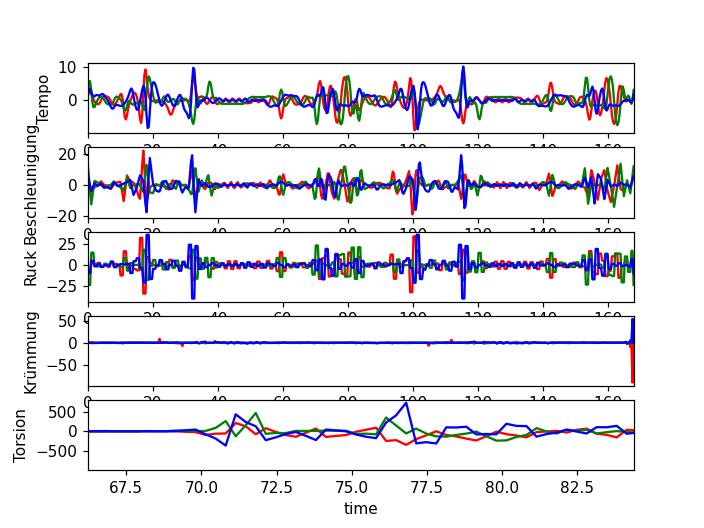

In [47]:
fig, axs = plt.subplots(5, 1)

# Set the x axis to max t value
for ax in axs:
    ax.set_xlim(0, data['ts'][len(data['ts'])-1])
    ax.set_xlabel('time')

# curve first deriv - tempo
axs[0].set_ylabel('Tempo')
axs[0].plot(data['ts'], data['speed'][:,0], label='x', c='r')
axs[0].plot(data['ts'], data['speed'][:,1], label='y', c='g')
axs[0].plot(data['ts'], data['speed'][:,2], label='z', c='b')

# curve second deriv - acceleration
axs[1].set_ylabel('Beschleunigung')
axs[1].plot(data['ts'], data['acceleration'][:,0], label='x', c='r')
axs[1].plot(data['ts'], data['acceleration'][:,1], label='y', c='g')
axs[1].plot(data['ts'], data['acceleration'][:,2], label='z', c='b')

# curve third deriv - jolt
axs[2].set_ylabel('Ruck')
axs[2].plot(data['ts'], data['jolt'][:,0], label='x', c='r')
axs[2].plot(data['ts'], data['jolt'][:,1], label='y', c='g')
axs[2].plot(data['ts'], data['jolt'][:,2], label='z', c='b')

# curvature
axs[3].set_ylabel('Krümmung')
axs[3].plot(data['ts'], data['curvature'][:,0], label='x', c='r')
axs[3].plot(data['ts'], data['curvature'][:,1], label='y', c='g')
axs[3].plot(data['ts'], data['curvature'][:,2], label='z', c='b')

# torsion 
axs[4].set_ylabel('Torsion')
axs[4].plot(data['ts'], data['torsion'][:,0], label='x', c='r')
axs[4].plot(data['ts'], data['torsion'][:,1], label='y', c='g')
axs[4].plot(data['ts'], data['torsion'][:,2], label='z', c='b')


plt.show()

# Runge Kutta Verfahren

In [17]:
acc = acceleration(all_curve_functions['bezier_cubics_first_deriv'][0], all_curve_functions['bezier_cubics_second_deriv'][0])

NameError: name 'acceleration' is not defined

In [18]:
# f = ode, x0 = initial condition, t0 = initial time, tf = final time, dt = sample time
def RungeKutta45(f, x0, t0, tf, dt):
    t = np.arange(t0, tf, dt)
    nt = t.size
    
    nx = x0.size
    x = np.zeros((nx, nt))
    
    x[:,0] = x0
    for k in range(nt - 1):
        
    

SyntaxError: unexpected EOF while parsing (<ipython-input-18-9c6e3622cf10>, line 12)

In [51]:
t0 = 0
y0 = all_curve_functions['bezier_cubics_first_deriv'][0](0)
t_bound = 1

Vel = RK45(acc, t0, y0, t_bound)


In [52]:
acc_ts = []
velocities = []
for i in range(100):
    # get solution step state
    Vel.step()
    acc_ts.append(Vel.t)
    velocities.append(Vel.y)
    # break loop after modeling is finished
    if Vel.status == 'finished':
        break
            
#velocities
len(acc_ts)

35

In [15]:
def get_vel_approximated(approximated_velocities, acc_ts):
    return lambda t,s: approximated_velocities[acc_ts.index(t)]

In [16]:
t0_vel = 0
y0_vel  = all_curve_functions['bezier_cubics'][0](0)
t_bound_vel = 1
Pos = RK45(get_vel_approximated(velocities, acc_ts), t0_vel, y0_vel, t_bound_vel)

NameError: name 'acc_ts' is not defined

# Deprecated Functions 

In [101]:
'''
# formular for the energy
def energy(bezier_cubic_first_deriv, bezier_cubic):
    return lambda t: 1/2 * get_mass() * np.power(bezier_cubic_first_deriv(t), 2) + get_mass() * np.dot(bezier_cubic(t), get_gravity())

# This functions returns the velocity in parametric space
def parametric_velocity(energy, bezier_cubic, bezier_cubic_first_deriv):
    return lambda t: np.sqrt((2* (energy(t) - get_mass() * np.dot(bezier_cubic(t), get_gravity()) )) / (get_mass() * np.power(bezier_cubic_first_deriv(t), 2)))

# This functions returns the acceleration in parametric space
#def parametric_acceleration(bezier_cubic, parametric_velocity, bezier_cubic_first_deriv, bezier_cubic_second_deriv):
    return lambda t,x: -(np.dot(bezier_cubic(t), get_gravity()) + np.power(parametric_velocity(t),2) * np.dot(bezier_cubic_first_deriv(t), bezier_cubic_second_deriv(t))) / np.power(bezier_cubic_first_deriv(t),2)



# this function simulates the acceleration for a specific curve in the rollercoaster
def acceleration(bezier_cubic_first_deriv, bezier_cubic_second_deriv):
    return lambda t, s_dot:  - ((np.dot(bezier_cubic_first_deriv(t), get_gravity()) + s_dot * np.dot(bezier_cubic_first_deriv(t), bezier_cubic_second_deriv(t)))/ np.power(bezier_cubic_first_deriv(t),2))
'''
# return one cubic curve for each consecutive points
'''
def get_bezier_cubic(points):
    A, B = get_bezier_coef(points)
    return [
        bezier_cubic(points[i], A[i], B[i], points[(i + 1)% len(points)])
        for i in range(len(points))
    ]
'''
'''
def get_dynamic_behaviour(functions, n, sample_count=100):
    energies = []
    velocities = []
    accelerations = []
    for t in np.linspace(0, n, sample_count * n):
        seperated_t = math.modf(t%n)
        segment_index = int(seperated_t[1])
        curve_index = seperated_t[0]

    
    energies = np.array(energies)
    velocities = np.array(velocities)
    accelerations = np.array(accelerations)
    
    return energies, velocities, accelerations
    
    #print("Energy: ", functions['energy_functions'][0](t))
    print("Velocity: ", functions['parametric_velocity_functions'][0](t))
    print("Acceleration: ", functions['parametric_acceleration_functions'][0](t))
'''
def get_curve_points(bezier_cubics, n, sample_count=100):
    curve_points = []
    for t in np.linspace(0, n, sample_count * n):
        seperated_t = math.modf(t%n)
        segment_index = int(seperated_t[1])
        curve_index = seperated_t[0]
        current_curve = bezier_cubics[segment_index]
        current_curve_point = current_curve(curve_index)
        curve_points.append(np.array(current_curve_point))
    return np.array(curve_points)


def get_curve_speeds(bezier_cubics_first_derivatives, n, sample_count=100):
    curve_points = []
    for t in np.linspace(0, n, sample_count * n):
        seperated_t = math.modf(t%n)
        segment_index = int(seperated_t[1])
        curve_index = seperated_t[0]
        current_curve = bezier_cubics_first_derivatives[segment_index]
        current_curve_point = current_curve(curve_index)
        curve_points.append(np.array(current_curve_point))
    return np.array(curve_points)
    
    
    
        for t1 in np.linspace(0, n, sample_count * n * 100):
        seperated_t1 = math.modf(t1%n)
        segment_index_1 = int(seperated_t1[1])
        curve_index_1 = seperated_t1[0]
        # here calculate all the values for the current t
        # curve point (pure geometry)
        current_curve_point_1 = all_curve_functions['bezier_cubics'][segment_index_1](curve_index_1) 
        
        # get approximated length of the curve at t
        current_length = abs(float(np.linalg.norm(current_curve_point_1 - last_curve_point)))

        total_length = last_length + current_length
        last_curve_point = current_curve_point

        length_of_curve_at_t.append(total_length)
        #last_euclidean_norm = current_euclidean_norm
        last_length = total_length
    # create an index I evenly distributet over the Length Values         
    i_max = n
    I = []
    total = length_of_curve_at_t[len(length_of_curve_at_t)-1]
    
    for loc in length_of_curve_at_t:
        percentage = loc/total
        I.append(round(n*percentage,10))
   
    ideal = {}        
    not_assigned = []
    counter = len(I)
    for index, i in enumerate(np.linspace(0,n,sample_count * n)):
        percentage_of_i = i/n
        
        found_matching = False
        
        for loc in length_of_curve_at_t:
            percentage_of_length = loc/total
            
            if (percentage_of_i == percentage_of_length):
                ideal[percentage_of_i] = percentage_of_length
                found_matching = True
        
        if (not found_matching):
            not_assigned.append(i)

    
    
'''
    

IndentationError: unexpected indent (<ipython-input-101-88d33de8677f>, line 75)

## Code for drawing acceleration and speed vectors  

In [102]:
    '''
    u_vel = data['speed'][num, 0]
    v_vel = data['speed'][num, 1]
    w_vel = data['speed'][num, 2]    
    
    global speed_vector
    speed_vector.remove()
    speed_vector = plt.quiver(x,y,z,u_vel,v_vel,w_vel, length=0.5, color='g' )

    u_acc = data['acceleration'][num, 0]
    v_acc = data['acceleration'][num, 1]
    w_acc = data['acceleration'][num, 2]
    
    global acceleration_vector
    acceleration_vector.remove()
    acceleration_vector = plt.quiver(x,y,z, u_acc, v_acc, w_acc, length=0.5, color='r')
    '''

"\nu_vel = data['speed'][num, 0]\nv_vel = data['speed'][num, 1]\nw_vel = data['speed'][num, 2]    \n\nglobal speed_vector\nspeed_vector.remove()\nspeed_vector = plt.quiver(x,y,z,u_vel,v_vel,w_vel, length=0.5, color='g' )\n\nu_acc = data['acceleration'][num, 0]\nv_acc = data['acceleration'][num, 1]\nw_acc = data['acceleration'][num, 2]\n\nglobal acceleration_vector\nacceleration_vector.remove()\nacceleration_vector = plt.quiver(x,y,z, u_acc, v_acc, w_acc, length=0.5, color='r')\n"

## Code for reading points as csv

In [101]:
'''
def create_points(filename):
    if (filename != ""):
        script_dir = os.path.dirname(filename+'.csv')
        rel_path = filename+'.csv'
        abs_file_path = os.path.join(script_dir, rel_path)
        points = []
        with open(abs_file_path, newline='') as csvfile:
            csvreader = csv.reader(csvfile, delimiter=",")
            
            for row in csvreader:
                points.append(np.array([row[0], row[1], row[2]], dtype=float))
        
        points = np.array(points)
    else: 
        #points = np.random.randfloat(10,3) * 3
        points = np.random.uniform(-10,10,[5,3])
    return points
    '''

'\ndef create_points(filename):\n    if (filename != ""):\n        script_dir = os.path.dirname(filename+\'.csv\')\n        rel_path = filename+\'.csv\'\n        abs_file_path = os.path.join(script_dir, rel_path)\n        points = []\n        with open(abs_file_path, newline=\'\') as csvfile:\n            csvreader = csv.reader(csvfile, delimiter=",")\n            \n            for row in csvreader:\n                points.append(np.array([row[0], row[1], row[2]], dtype=float))\n        \n        points = np.array(points)\n    else: \n        #points = np.random.randfloat(10,3) * 3\n        points = np.random.uniform(-10,10,[5,3])\n    return points\n    '